###  Load Data and Setup Analysis Environment

In [ ]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Any
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load the data

data_path = "../data/captions_with_srl_roles.parquet"
df = pd.read_parquet(data_path)
print(f"Loaded {len(df)} images with SRL data")
print(f"Columns: {list(df.columns)}")
df.head()

Loaded 105883 images with SRL data
Columns: ['image_id', 'image_url', 'caption', 'blip_caption', 'actors', 'patients', 'scenes']


,image_id,image_url,caption,blip_caption,actors,patients,scenes
0,9474f089-1c19-4313-b6c8-1efb21b8681d,https://image.cnbcfm.com/api/v1/image/10731321...,US President Joe Biden addresses the terrorist...,bider is shown in the white house,"[US President Joe Biden, the White House, Pres...","[terrorist, Washington DC, the terrorist attac...","[Washington, DC, DC, ,, State Dining Room of t..."
1,b4beed8b-db2b-4785-a27c-a6006be09c51,https://image.cnbcfm.com/api/v1/image/10731318...,Israeli Prime Minister Benjamin Netanyahu (3rd...,a group of people sitting around a table,"[Israeli Prime Minister Benjamin Netanyahu, se...","[Tel Aviv Israel, Israeli Prime Minister Benja...","[Tel Aviv, Israel, Tel, 3rd L]"
2,fd09ee0f-bf29-4c6b-a78e-fe6dd797050c,https://image.cnbcfm.com/api/v1/image/10731316...,Israelis inspect damage caused by a rocket att...,a man standing in front of a pile of junk cars,"[Palestinian militants, Israelis, the Israeli ...","[a rocket attack Gaza, rockets, dozens rockets...",[Gaza]
3,9fe7085d-04a5-4618-81e4-9a1d2f16d1f0,https://image.cnbcfm.com/api/v1/image/10724685...,U.S. Defense Secretary Lloyd Austin speaks dur...,a man in a suit and tie speaking at a podium,"[Mark Milley, U.S. Defense Secretary Lloyd Aus...",[an online meeting the Ukraine Defense Contact...,"[U.S., Pentagon, Washington, the Pentagon]"
4,496d9eda-d99a-4164-9d2e-67c5454acf27,https://image.cnbcfm.com/api/v1/image/10730523...,U.S. Secretary of State Antony Blinken testifi...,a man in a suit and tie sitting at a table,"[Secretary of State, Senate Foreign Relations ...","[Senate Foreign Relations Committee, Washingto...","[U.S., Washington, Antony Blinken]"


### Load the NER entities and violence keywords

In [3]:
# Define Israel-related entities
israel_entities = {
    "israel", "israeli", "israelis", "zionist", "zionists",
    "idf", "israel defense forces", "israeli defense forces", "tzahal",
    "shin bet", "mossad", "aman", "israeli military", "israeli army",
    "israeli forces", "israeli soldiers", "israeli troops",
    "netanyahu", "benjamin netanyahu", "bibi", "binyamin netanyahu",
    "gantz", "benny gantz", "lapid", "yair lapid", "bennett", "naftali bennett",
    "gallant", "yoav gallant", "smotrich", "ben gvir", "itamar ben gvir",
    "likud", "blue and white", "kahol lavan", "yesh atid", "yamina",
    "knesset", "israeli parliament", "israeli government",
    "jerusalem", "tel aviv", "haifa", "ashdod", "beersheba", "eilat",
    "nazareth", "petah tikva", "rishon lezion", "rehovot", "bat yam",
    "holon", "bnei brak", "ramat gan", "ashkelon", "netanya",
    "kiryat gat", "sderot", "ofakim", "dimona",
    "galilee", "negev", "golan heights", "judea", "samaria",
    "west jerusalem", "east jerusalem", "jewish quarter",
    "kibbutz", "kibbutzim", "moshav", "settlement", "settlements",
    "settler", "settlers", "israeli settlement", "israeli settlements",
    "outpost", "outposts", "colony", "colonies"
}

# Define Palestine/Gaza-related entities
palestine_entities = {
    "gaza", "gaza strip", "gazans", "gazan", "gaza city",
    "palestine", "palestinian", "palestinians", "state of palestine",
    "west bank", "westbank", "occupied west bank",
    "rafah", "jabalia", "jabalya", "nuseirat", "deir al balah", "deir al-balah",
    "khan younis", "khan yunis", "beit hanoun", "beit lahia",
    "gaza city", "northern gaza", "southern gaza", "central gaza",
    "ramallah", "hebron", "al khalil", "bethlehem", "beit lahm",
    "nablus", "jenin", "tulkarm", "qalqilya", "salfit",
    "jericho", "ariha", "east jerusalem", "arab jerusalem",
    "hamas", "harakat al-muqawama al-islamiyya", "islamic resistance movement",
    "islamic jihad", "palestinian islamic jihad", "pij",
    "fatah", "harakat al-tahrir al-watani al-filastini",
    "plo", "palestine liberation organization",
    "pa", "palestinian authority", "palestinian national authority",
    "pflp", "popular front", "dflp", "democratic front",
    "qassam", "al-qassam", "izz ad-din al-qassam", "qassam brigades",
    "aqsa martyrs", "al-aqsa martyrs brigades", "al aqsa martyrs",
    "saraya al-quds", "quds brigades",
    "abbas", "mahmoud abbas", "abu mazen", "haniyeh", "ismail haniyeh",
    "sinwar", "yahya sinwar", "meshaal", "khaled meshaal",
    "barghouti", "marwan barghouti", "erekat", "saeb erekat",
    "shifa", "al-shifa", "al shifa hospital", "shifa hospital",
    "al-quds hospital", "indonesian hospital", "european hospital"
}

# Define violence keywords by category
violence_keywords = {
    "destruction": ["destroyed", "demolished", "rubble", "debris", "ruins", "devastated", "flattened", "collapsed"],
    "casualties": ["killed", "dead", "wounded", "injured", "casualties", "victims", "fatalities", "deaths", "dies", "died"],
    "weapons": ["rockets", "missiles", "bombs", "artillery", "airstrikes", "mortars", "explosives", "grenades", "gunfire"],
    "conflict": ["attack", "strike", "raid", "operation", "battle", "fighting", "combat", "assault", "offensive", "bombardment"],
    "medical": ["hospital", "ambulance", "medical", "clinic", "doctor", "nurse", "patient", "emergency"],
    "civilian": ["civilian", "children", "women", "family", "school", "home", "house", "refugee"]
}

print("Entity sets and violence keywords defined")
print(f"Israel entities: {len(israel_entities)}")
print(f"Palestine entities: {len(palestine_entities)}")
print(f"Violence categories: {list(violence_keywords.keys())}")

Entity sets and violence keywords defined
Israel entities: 81
Palestine entities: 85
Violence categories: ['destruction', 'casualties', 'weapons', 'conflict', 'medical', 'civilian']


### Identifying primary entity (helper methods)

In [4]:
def extract_entities_safe(entities):
    """Safely extract and clean entities from various formats"""
    if entities is None or (hasattr(entities, '__len__') and len(entities) == 0):
        return []
    
    # Handle numpy arrays
    if isinstance(entities, np.ndarray):
        if entities.size == 0:
            return []
        entities_list = entities.tolist()
    elif isinstance(entities, str):
        try:
            entities_list = ast.literal_eval(entities) if entities.strip() else []
        except:
            return []
    elif isinstance(entities, list):
        entities_list = entities
    else:
        return []
    
    # Clean and filter entities
    result = []
    for entity in entities_list:
        if entity is not None and not pd.isna(entity):
            entity_str = str(entity).strip()
            if entity_str:  # Only add non-empty strings
                result.append(entity_str)
    
    return result

def contains_entity(text, entity_set):
    """Check if text contains any entity from the given set"""
    if not text or pd.isna(text):
        return False
    text_lower = str(text).lower()
    for entity in entity_set:
        if re.search(r'\b' + re.escape(entity) + r'\b', text_lower):
            return True
    return False

def get_text_for_analysis(row):
    """Get the best available text for analysis"""
    if pd.notna(row.get('caption', '')) and str(row.get('caption', '')).strip():
        return str(row['caption'])
    elif pd.notna(row.get('blip_caption', '')) and str(row.get('blip_caption', '')).strip():
        return str(row['blip_caption'])
    else:
        return ""

print("Helper functions defined")

Helper functions defined


### Identify primary actors in image using the caption

In [5]:
def identify_primary_actor_enhanced(row):
    """Enhanced primary actor identification using SRL results + entity matching"""
    try:
        # Extract SRL entities with better array handling
        actors = extract_entities_safe(row.get('actors', []))
        patients = extract_entities_safe(row.get('patients', []))
        scenes = extract_entities_safe(row.get('scenes', []))
        
        # Priority scoring: actors (3x) > patients (2x) > scenes (1x)
        all_entities = []
        if actors:
            all_entities.extend([(entity, 3) for entity in actors])
        if patients:
            all_entities.extend([(entity, 2) for entity in patients])
        if scenes:
            all_entities.extend([(entity, 1) for entity in scenes])
        
        # Score entities using enhanced matching
        israel_score = 0
        palestine_score = 0
        
        for entity, weight in all_entities:
            if contains_entity(entity, israel_entities):
                israel_score += weight
            elif contains_entity(entity, palestine_entities):
                palestine_score += weight
        
        # If SRL doesn't give clear answer, fall back to caption analysis
        if abs(israel_score - palestine_score) < 1:
            return analyze_caption_fallback(row.get('caption', '') or row.get('blip_caption', ''))
        
        if israel_score > palestine_score:
            return "Israel"
        elif palestine_score > israel_score:
            return "Gaza/Palestine"
        else:
            return "Neutral"
            
    except Exception as e:
        print(f"Error processing row: {e}")
        # Fallback to caption analysis if SRL fails
        return analyze_caption_fallback(row.get('caption', '') or row.get('blip_caption', ''))

def analyze_caption_fallback(caption):
    """Fallback caption analysis"""
    if not caption or pd.isna(caption):
        return "Neutral"
    
    caption_lower = str(caption).lower()
    
    # Count entity occurrences
    israel_count = sum(1 for entity in israel_entities if entity in caption_lower)
    palestine_count = sum(1 for entity in palestine_entities if entity in caption_lower)
    
    # Context patterns for primary actors
    israel_patterns = [
        r"israeli?\s+(airstrike|bombardment|attack|operation|forces)",
        r"idf\s+(forces|soldiers|troops|announces|conducts)",
        r"israel\s+(launches|conducts|carries out|attacks)"
    ]
    
    palestine_patterns = [
        r"hamas\s+(fires|launches|attacks|claims|militants)",
        r"palestinian\s+(militants|fighters|rockets|forces)",
        r"gaza\s+(fires|launches|militants)"
    ]
    
    israel_pattern_score = sum(1 for pattern in israel_patterns if re.search(pattern, caption_lower))
    palestine_pattern_score = sum(1 for pattern in palestine_patterns if re.search(pattern, caption_lower))
    
    # Combine scores
    total_israel = israel_count + israel_pattern_score
    total_palestine = palestine_count + palestine_pattern_score
    
    if total_israel > total_palestine and total_israel > 0:
        return "Israel"
    elif total_palestine > total_israel and total_palestine > 0:
        return "Gaza/Palestine"
    else:
        return "Neutral"

# Apply primary actor identification
print("Identifying primary actors...")
df['text_for_analysis'] = df.apply(get_text_for_analysis, axis=1)
df['primary_actor_enhanced'] = df.apply(identify_primary_actor_enhanced, axis=1)

# Show results
actor_counts = df['primary_actor_enhanced'].value_counts()
print("\nPrimary Actor Distribution:")
for actor, count in actor_counts.items():
    percentage = count / len(df) * 100
    print(f"  {actor:15s}: {count:4d} ({percentage:5.1f}%)")

Identifying primary actors...

Primary Actor Distribution:
  Israel         : 40052 ( 37.8%)
  Gaza/Palestine : 39115 ( 36.9%)
  Neutral        : 26716 ( 25.2%)


### Vader Sentiment Score calculation

In [6]:
# Initialize VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    """Analyze sentiment of text using both TextBlob and VADER"""
    if pd.isna(text) or not text:
        return {'polarity': 0, 'subjectivity': 0, 'category': 'neutral', 'vader_compound': 0}
    
    # TextBlob sentiment
    blob = TextBlob(str(text))
    polarity = blob.sentiment.polarity
    
    # VADER sentiment
    vader_scores = vader.polarity_scores(str(text))
    vader_compound = vader_scores['compound']
    
    # Categorize based on average of both
    avg_sentiment = (polarity + vader_compound) / 2
    
    if avg_sentiment > 0.1:
        category = 'positive'
    elif avg_sentiment < -0.1:
        category = 'negative'
    else:
        category = 'neutral'
        
    return {
        'polarity': polarity,
        'subjectivity': blob.sentiment.subjectivity,
        'vader_compound': vader_compound,
        'avg_sentiment': avg_sentiment,
        'category': category
    }

print("Analyzing sentiment...")
sentiment_results = df['text_for_analysis'].apply(analyze_sentiment)

# Extract sentiment metrics
df['sentiment_polarity'] = sentiment_results.apply(lambda x: x['polarity'])
df['sentiment_subjectivity'] = sentiment_results.apply(lambda x: x['subjectivity'])
df['sentiment_vader'] = sentiment_results.apply(lambda x: x['vader_compound'])
df['avg_sentiment'] = sentiment_results.apply(lambda x: x['avg_sentiment'])
df['sentiment_category'] = sentiment_results.apply(lambda x: x['category'])

print("Sentiment analysis complete!")
print(f"Average sentiment: {df['avg_sentiment'].mean():.3f}")
print("\nSentiment distribution:")
sentiment_dist = df['sentiment_category'].value_counts(normalize=True)
for category, pct in sentiment_dist.items():
    print(f"  {category}: {pct:.1%}")

Analyzing sentiment...
Sentiment analysis complete!
Average sentiment: -0.081

Sentiment distribution:
  neutral: 43.2%
  negative: 40.3%
  positive: 16.5%


### Analyse violence indicators (framing patterns as well)

In [7]:
def count_violence_indicators(text):
    """Count violence-related terms by category"""
    if pd.isna(text) or not text:
        return {category: 0 for category in violence_keywords.keys()}
    
    text_lower = str(text).lower()
    results = {}
    
    for category, terms in violence_keywords.items():
        count = 0
        for term in terms:
            count += len(re.findall(r'\b' + re.escape(term) + r'\b', text_lower))
        results[category] = count
        
    return results

print("Analyzing violence indicators...")
violence_results = df['text_for_analysis'].apply(count_violence_indicators)
df['violence_indicators'] = violence_results
df['total_violence_score'] = violence_results.apply(lambda x: sum(x.values()))

print("Violence analysis complete!")
print(f"Average violence score: {df['total_violence_score'].mean():.2f}")

# Show violence by category
violence_by_category = defaultdict(int)
for violence_dict in df['violence_indicators']:
    for category, count in violence_dict.items():
        violence_by_category[category] += count

print("\nViolence indicators by category:")
for category, total in violence_by_category.items():
    print(f"  {category}: {total}")

Analyzing violence indicators...
Violence analysis complete!
Average violence score: 0.58

Violence indicators by category:
  destruction: 6680
  casualties: 11332
  weapons: 4272
  conflict: 16451
  medical: 6964
  civilian: 16039


### Generate bias plots

In [8]:
def generate_bias_report():
    """Generate comprehensive bias analysis report"""
    
    # Overview statistics
    actor_counts = df['primary_actor_enhanced'].value_counts()
    total_images = len(df)
    
    overview = {
        'total_images_analyzed': total_images,
        'actor_counts': actor_counts.to_dict(),
        'actor_percentages': (actor_counts / total_images * 100).to_dict(),
        'sentiment_overview': {
            'avg_sentiment': df['avg_sentiment'].mean(),
            'sentiment_std': df['avg_sentiment'].std(),
            'sentiment_distribution': df['sentiment_category'].value_counts(normalize=True).to_dict()
        }
    }
    
    # Sentiment bias analysis by actor
    sentiment_bias = {}
    for actor in df['primary_actor_enhanced'].unique():
        if pd.isna(actor):
            continue
            
        actor_data = df[df['primary_actor_enhanced'] == actor]
        
        # Aggregate violence indicators
        violence_totals = defaultdict(int)
        for violence_dict in actor_data['violence_indicators']:
            for category, count in violence_dict.items():
                violence_totals[category] += count
        
        sentiment_bias[actor] = {
            'count': len(actor_data),
            'avg_sentiment_textblob': actor_data['sentiment_polarity'].mean(),
            'avg_sentiment_vader': actor_data['sentiment_vader'].mean(),
            'avg_sentiment_combined': actor_data['avg_sentiment'].mean(),
            'sentiment_std': actor_data['avg_sentiment'].std(),
            'sentiment_distribution': actor_data['sentiment_category'].value_counts(normalize=True).to_dict(),
            'violence_indicators': dict(violence_totals),
            'total_violence_score': actor_data['total_violence_score'].mean()
        }
    
    # Bias indicators
    bias_indicators = {}
    
    # Sentiment disparity analysis
    primary_actors = ["Israel", "Gaza/Palestine"]
    actors_with_data = [actor for actor in primary_actors 
                       if actor in df['primary_actor_enhanced'].values and 
                       len(df[df['primary_actor_enhanced'] == actor]) > 5]
    
    if len(actors_with_data) >= 2:
        israel_data = df[df['primary_actor_enhanced'] == 'Israel']
        palestine_data = df[df['primary_actor_enhanced'] == 'Gaza/Palestine']
        
        israel_sentiment = israel_data['avg_sentiment'].mean()
        palestine_sentiment = palestine_data['avg_sentiment'].mean()
        
        sentiment_diff = israel_sentiment - palestine_sentiment
        
        bias_indicators['sentiment_disparity'] = {
            'israel_avg': israel_sentiment,
            'palestine_avg': palestine_sentiment,
            'difference': sentiment_diff,
            'absolute_difference': abs(sentiment_diff),
            'potential_bias': abs(sentiment_diff) > 0.15,
            'bias_direction': "pro-Israel" if sentiment_diff > 0.15 else "pro-Palestine" if sentiment_diff < -0.15 else "balanced"
        }
        
        # Coverage bias
        israel_count = len(israel_data)
        palestine_count = len(palestine_data)
        total_relevant = israel_count + palestine_count
        
        if total_relevant > 0:
            bias_indicators['coverage_bias'] = {
                'israel_coverage': israel_count / total_relevant,
                'palestine_coverage': palestine_count / total_relevant,
                'imbalance': abs(israel_count - palestine_count) / total_relevant,
                'potential_bias': abs(israel_count - palestine_count) / total_relevant > 0.3
            }
        
        # Violence framing bias
        israel_violence = israel_data['total_violence_score'].mean()
        palestine_violence = palestine_data['total_violence_score'].mean()
        
        bias_indicators['violence_framing_bias'] = {
            'israel_avg_violence': israel_violence,
            'palestine_avg_violence': palestine_violence,
            'violence_difference': israel_violence - palestine_violence,
            'potential_bias': abs(israel_violence - palestine_violence) > 1.0
        }
    
    return {
        'overview': overview,
        'sentiment_bias': sentiment_bias,
        'bias_indicators': bias_indicators
    }

# Generate the report
print("Generating comprehensive bias report...")
report = generate_bias_report()

print("\n" + "="*60)
print("COMPREHENSIVE BIAS ANALYSIS SUMMARY")
print("="*60)

print(f"Total images analyzed: {report['overview']['total_images_analyzed']}")
print(f"Overall sentiment: {report['overview']['sentiment_overview']['avg_sentiment']:.3f}")

print("\nActor distribution:")
for actor, percentage in report['overview']['actor_percentages'].items():
    count = report['overview']['actor_counts'][actor]
    print(f"  {actor:15s}: {count:4d} ({percentage:5.1f}%)")

print("\nSentiment bias analysis:")
for actor, data in report['sentiment_bias'].items():
    if actor in ["Israel", "Gaza/Palestine"] and data['count'] > 5:
        print(f"  {actor:15s}: {data['avg_sentiment_combined']:6.3f} avg sentiment (n={data['count']})")

if "sentiment_disparity" in report.get("bias_indicators", {}):
    disparity = report["bias_indicators"]["sentiment_disparity"]
    print(f"\nSentiment disparity: {disparity['difference']:6.3f}")
    print(f"Bias direction: {disparity['bias_direction']}")
    if disparity['potential_bias']:
        print("⚠️  Potential sentiment bias detected!")

if "coverage_bias" in report.get("bias_indicators", {}):
    coverage = report["bias_indicators"]["coverage_bias"]
    print(f"\nCoverage imbalance: {coverage['imbalance']:.3f}")
    if coverage['potential_bias']:
        print("⚠️  Potential coverage bias detected!")

if "violence_framing_bias" in report.get("bias_indicators", {}):
    violence = report["bias_indicators"]["violence_framing_bias"]
    print(f"\nViolence framing difference: {violence['violence_difference']:.3f}")
    if violence['potential_bias']:
        print("⚠️  Potential violence framing bias detected!")

print("\n" + "="*60)

Generating comprehensive bias report...

COMPREHENSIVE BIAS ANALYSIS SUMMARY
Total images analyzed: 105883
Overall sentiment: -0.081

Actor distribution:
  Israel         : 40052 ( 37.8%)
  Gaza/Palestine : 39115 ( 36.9%)
  Neutral        : 26716 ( 25.2%)

Sentiment bias analysis:
  Israel         : -0.108 avg sentiment (n=40052)
  Gaza/Palestine : -0.097 avg sentiment (n=39115)

Sentiment disparity: -0.012
Bias direction: balanced

Coverage imbalance: 0.012

Violence framing difference: -0.068



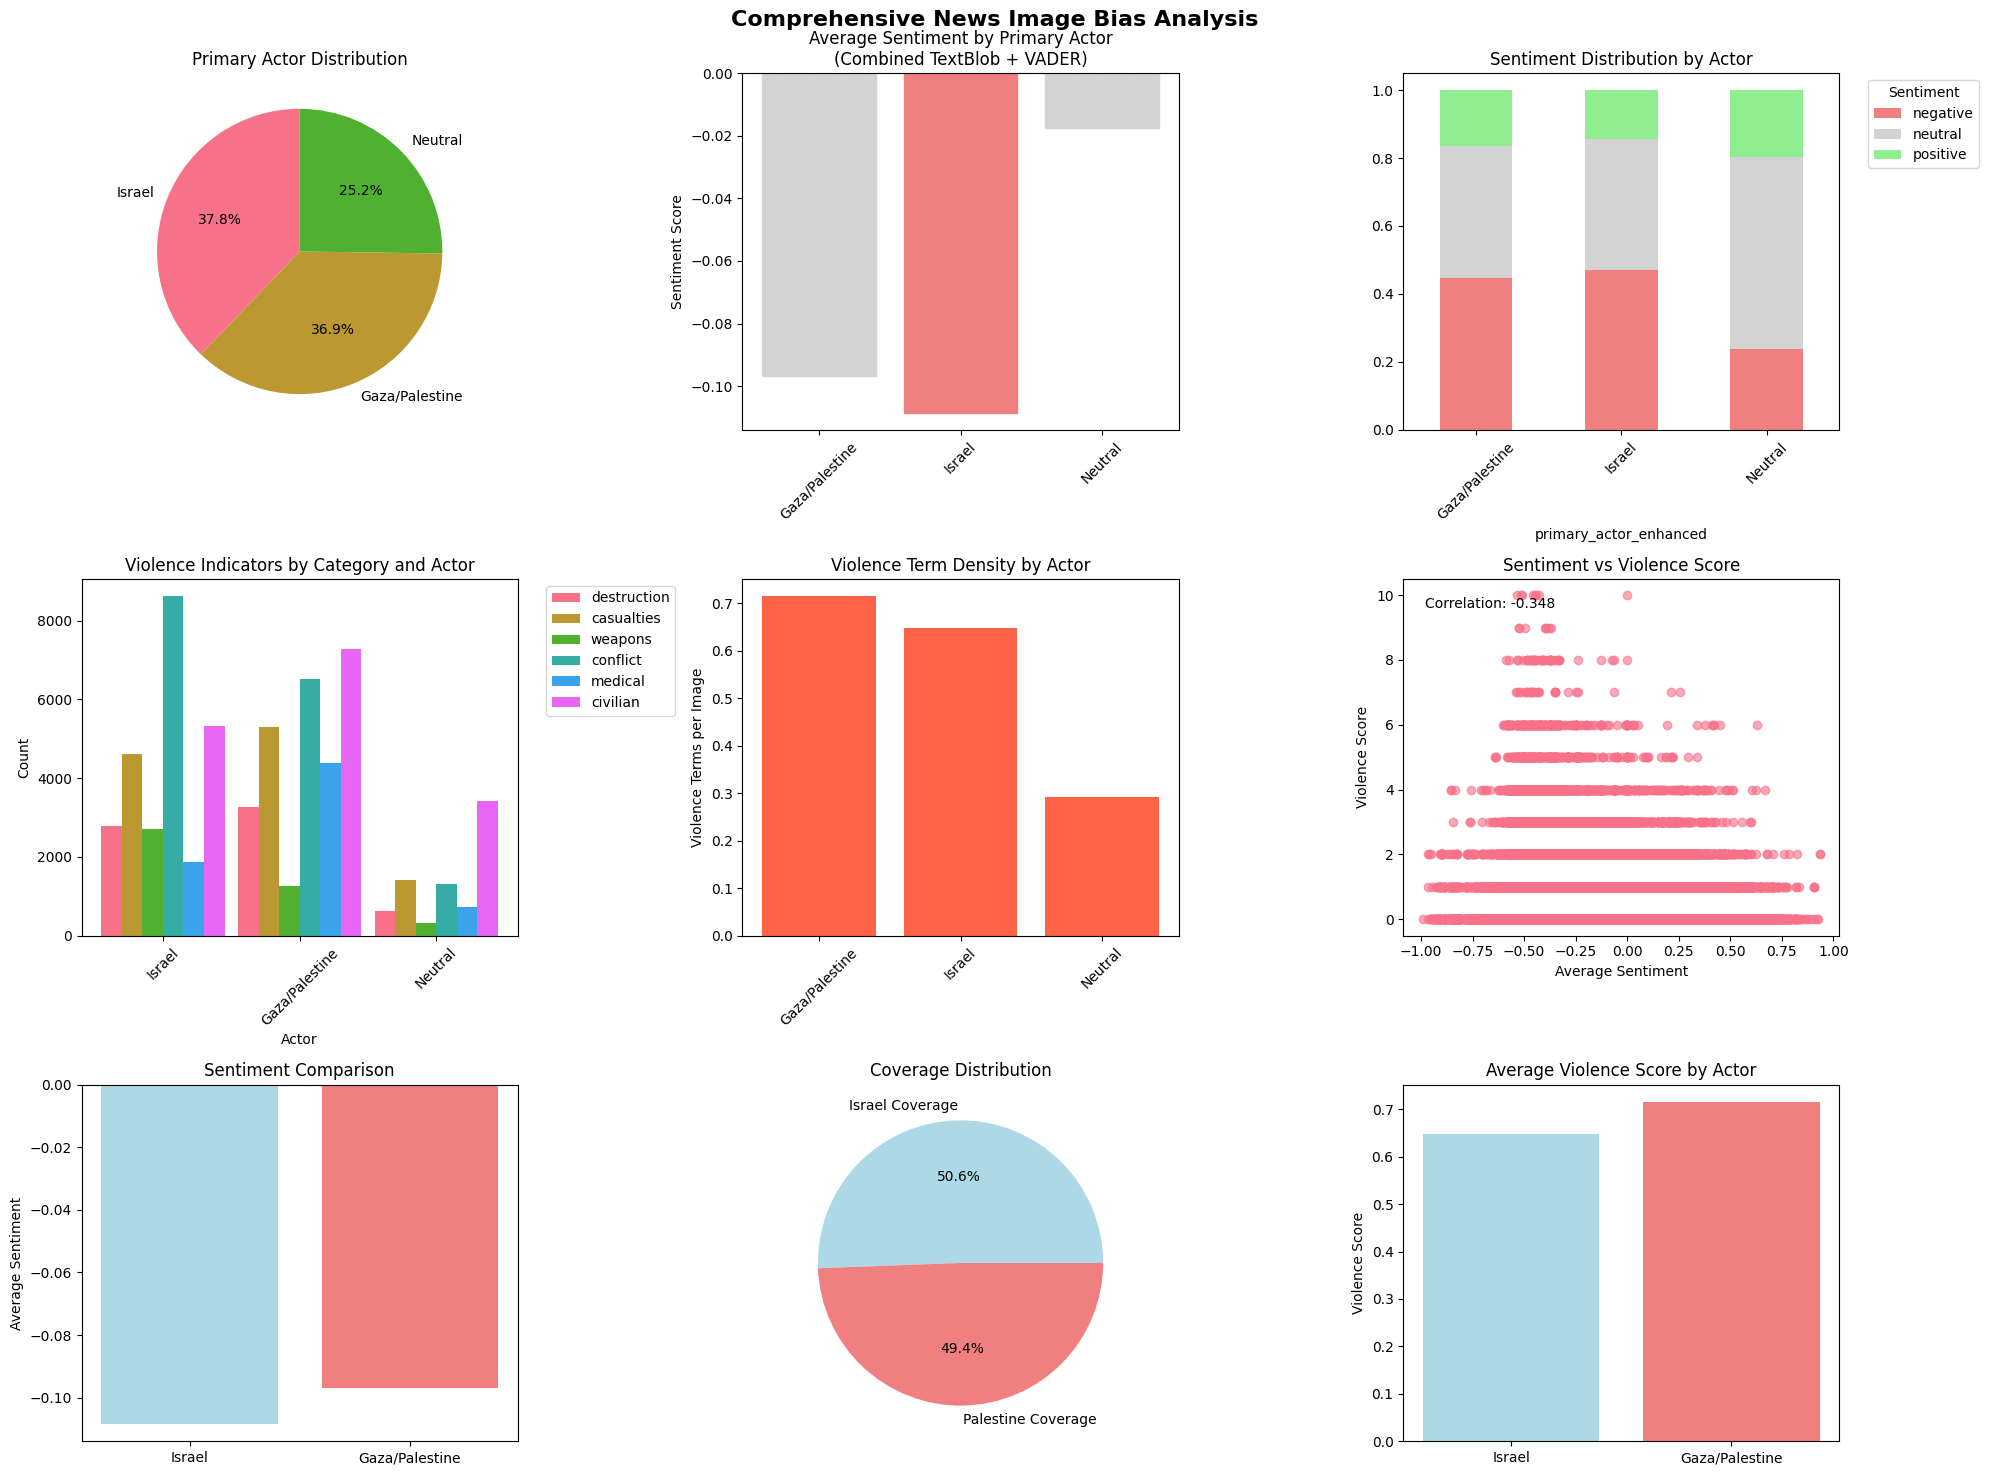

In [9]:
# Create comprehensive bias analysis visualizations
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle("Comprehensive News Image Bias Analysis", fontsize=16, fontweight='bold')

# 1. Actor Distribution
actor_counts = df["primary_actor_enhanced"].value_counts()
axes[0, 0].pie(actor_counts.values, labels=actor_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title("Primary Actor Distribution")

# 2. Combined Sentiment by Actor
sentiment_by_actor = df.groupby("primary_actor_enhanced")["avg_sentiment"].mean()
bars = axes[0, 1].bar(sentiment_by_actor.index, sentiment_by_actor.values)
axes[0, 1].set_title("Average Sentiment by Primary Actor\n(Combined TextBlob + VADER)")
axes[0, 1].set_ylabel("Sentiment Score")
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0, 1].tick_params(axis='x', rotation=45)

# Color bars based on sentiment
for bar, sentiment in zip(bars, sentiment_by_actor.values):
    if sentiment > 0.1:
        bar.set_color('lightgreen')
    elif sentiment < -0.1:
        bar.set_color('lightcoral')
    else:
        bar.set_color('lightgray')

# 3. Sentiment Distribution by Actor
sentiment_pivot = pd.crosstab(df["primary_actor_enhanced"], df["sentiment_category"], normalize='index')
sentiment_pivot.plot(kind='bar', stacked=True, ax=axes[0, 2], 
                    color=['lightcoral', 'lightgray', 'lightgreen'])
axes[0, 2].set_title("Sentiment Distribution by Actor")
axes[0, 2].legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Violence Indicators by Category and Actor
actors = ['Israel', 'Gaza/Palestine', 'Neutral']
categories = ['destruction', 'casualties', 'weapons', 'conflict', 'medical', 'civilian']

x = np.arange(len(actors))
width = 0.15

for i, category in enumerate(categories):
    values = []
    for actor in actors:
        actor_data = df[df['primary_actor_enhanced'] == actor]
        category_total = sum(violence_dict.get(category, 0) for violence_dict in actor_data['violence_indicators'])
        values.append(category_total)
    axes[1, 0].bar(x + i * width, values, width, label=category)

axes[1, 0].set_title('Violence Indicators by Category and Actor')
axes[1, 0].set_xlabel('Actor')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticks(x + width * 2.5)
axes[1, 0].set_xticklabels(actors, rotation=45)
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 5. Violence Density Comparison
violence_density = []
for actor in df['primary_actor_enhanced'].unique():
    if not pd.isna(actor):
        actor_data = df[df['primary_actor_enhanced'] == actor]
        density = actor_data['total_violence_score'].mean()
        violence_density.append((actor, density))

violence_density.sort(key=lambda x: x[1], reverse=True)

if violence_density:
    actors_vd, densities = zip(*violence_density)
    axes[1, 1].bar(actors_vd, densities, color='tomato')
    axes[1, 1].set_title('Violence Term Density by Actor')
    axes[1, 1].set_ylabel('Violence Terms per Image')
    axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Sentiment vs Violence Correlation
axes[1, 2].scatter(df['avg_sentiment'], df['total_violence_score'], alpha=0.6)
axes[1, 2].set_xlabel('Average Sentiment')
axes[1, 2].set_ylabel('Violence Score')
axes[1, 2].set_title('Sentiment vs Violence Score')

# Add correlation coefficient
correlation = df['avg_sentiment'].corr(df['total_violence_score'])
axes[1, 2].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=axes[1, 2].transAxes, verticalalignment='top')

# 7-9. Bias Indicators Summary
if "bias_indicators" in report:
    bias_data = report["bias_indicators"]
    
    if "sentiment_disparity" in bias_data:
        sentiment_bias = bias_data["sentiment_disparity"]
        axes[2, 0].bar(["Israel", "Gaza/Palestine"], 
                      [sentiment_bias["israel_avg"], sentiment_bias["palestine_avg"]],
                      color=['lightblue', 'lightcoral'])
        axes[2, 0].set_title('Sentiment Comparison')
        axes[2, 0].set_ylabel('Average Sentiment')
        axes[2, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    if "coverage_bias" in bias_data:
        coverage_bias = bias_data["coverage_bias"]
        axes[2, 1].pie([coverage_bias["israel_coverage"], coverage_bias["palestine_coverage"]], 
                      labels=["Israel Coverage", "Palestine Coverage"], 
                      autopct='%1.1f%%',
                      colors=['lightblue', 'lightcoral'])
        axes[2, 1].set_title('Coverage Distribution')
    
    if "violence_framing_bias" in bias_data:
        violence_bias = bias_data["violence_framing_bias"]
        axes[2, 2].bar(["Israel", "Gaza/Palestine"], 
                      [violence_bias["israel_avg_violence"], violence_bias["palestine_avg_violence"]],
                      color=['lightblue', 'lightcoral'])
        axes[2, 2].set_title('Average Violence Score by Actor')
        axes[2, 2].set_ylabel('Violence Score')

plt.tight_layout()
plt.show()

### Analysis across different sources

In [13]:
df

,image_id,image_url,caption,blip_caption,actors,patients,scenes,text_for_analysis,primary_actor_enhanced,sentiment_polarity,sentiment_subjectivity,sentiment_vader,avg_sentiment,sentiment_category,violence_indicators,total_violence_score
0,9474f089-1c19-4313-b6c8-1efb21b8681d,https://image.cnbcfm.com/api/v1/image/10731321...,US President Joe Biden addresses the terrorist...,bider is shown in the white house,"[US President Joe Biden, the White House, Pres...","[terrorist, Washington DC, the terrorist attac...","[Washington, DC, DC, ,, State Dining Room of t...",US President Joe Biden addresses the terrorist...,Israel,0.000,0.000,-0.8225,-0.41125,negative,"{'destruction': 0, 'casualties': 0, 'weapons':...",1
1,b4beed8b-db2b-4785-a27c-a6006be09c51,https://image.cnbcfm.com/api/v1/image/10731318...,Israeli Prime Minister Benjamin Netanyahu (3rd...,a group of people sitting around a table,"[Israeli Prime Minister Benjamin Netanyahu, se...","[Tel Aviv Israel, Israeli Prime Minister Benja...","[Tel Aviv, Israel, Tel, 3rd L]",Israeli Prime Minister Benjamin Netanyahu (3rd...,Israel,0.000,0.000,0.3400,0.17000,positive,"{'destruction': 0, 'casualties': 0, 'weapons':...",0
2,fd09ee0f-bf29-4c6b-a78e-fe6dd797050c,https://image.cnbcfm.com/api/v1/image/10731316...,Israelis inspect damage caused by a rocket att...,a man standing in front of a pile of junk cars,"[Palestinian militants, Israelis, the Israeli ...","[a rocket attack Gaza, rockets, dozens rockets...",[Gaza],Israelis inspect damage caused by a rocket att...,Gaza/Palestine,0.100,0.650,-0.8720,-0.38600,negative,"{'destruction': 0, 'casualties': 0, 'weapons':...",2
3,9fe7085d-04a5-4618-81e4-9a1d2f16d1f0,https://image.cnbcfm.com/api/v1/image/10724685...,U.S. Defense Secretary Lloyd Austin speaks dur...,a man in a suit and tie speaking at a podium,"[Mark Milley, U.S. Defense Secretary Lloyd Aus...",[an online meeting the Ukraine Defense Contact...,"[U.S., Pentagon, Washington, the Pentagon]",U.S. Defense Secretary Lloyd Austin speaks dur...,Neutral,0.000,0.100,0.2500,0.12500,positive,"{'destruction': 0, 'casualties': 0, 'weapons':...",0
4,496d9eda-d99a-4164-9d2e-67c5454acf27,https://image.cnbcfm.com/api/v1/image/10730523...,U.S. Secretary of State Antony Blinken testifi...,a man in a suit and tie sitting at a table,"[Secretary of State, Senate Foreign Relations ...","[Senate Foreign Relations Committee, Washingto...","[U.S., Washington, Antony Blinken]",U.S. Secretary of State Antony Blinken testifi...,Neutral,-0.125,0.125,0.0000,-0.06250,neutral,"{'destruction': 0, 'casualties': 0, 'weapons':...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105878,e7d2a8bf-7681-4f51-a092-63035c7b4863,https://static.independent.co.uk/2023/10/07/15...,Hamas launched an unprecedented incursion acro...,a man standing in front of a fire,"[Hamas, firing thousands of rockets in a shock...","[land, sea and air, rockets, Hamas, thousands ...","[Gaza, across the heavily fortified border wit...",Hamas launched an unprecedented incursion acro...,Gaza/Palestine,0.200,0.700,-0.7650,-0.28250,negative,"{'destruction': 0, 'casualties': 0, 'weapons':...",2
105879,c36dffef-6db1-4af4-9ffc-faa564b94fb8,https://static.independent.co.uk/2023/10/07/20...,Palestinians break into the Israeli side of Is...,a bull bull bull bull bull bull bull bull bull...,"[Reuters, Palestinians break into the Israeli ...","[gunmen infiltrated areas of southern Israel, ...",[Israel - Gaza border fence after gunmen infil...,Palestinians break into the Israeli side of Is...,Israel,0.000,0.000,0.0000,0.00000,neutral,"{'destruction': 0, 'casualties': 0, 'weapons':...",0
105880,799ab3f9-8142-44df-855e-1ea210c7b9f8,https://static.independent.co.uk/2023/10/07/20...,Rockets are fired from Gaza toward Israel ( Re...,a large explosion of a missile,"[Israel ( Reuters ), Rockets, Rockets are fire...","[Rockets, Gaza, Israel, Israel Reuters]","[Gaza, Israel]",Rockets are fired from Gaza toward Israel ( Re...,Israel,0.000,0.000,-0.5574,

,image_id,image_url,caption,blip_caption,actors,patients,scenes,text_for_analysis,primary_actor_enhanced,sentiment_polarity,sentiment_subjectivity,sentiment_vader,avg_sentiment,sentiment_category,violence_indicators,total_violence_score,source
0,9474f089-1c19-4313-b6c8-1efb21b8681d,https://image.cnbcfm.com/api/v1/image/10731321...,US President Joe Biden addresses the terrorist...,bider is shown in the white house,"[US President Joe Biden, the White House, Pres...","[terrorist, Washington DC, the terrorist attac...","[Washington, DC, DC, ,, State Dining Room of t...",US President Joe Biden addresses the terrorist...,Israel,0.000,0.000,-0.8225,-0.41125,negative,"{'destruction': 0, 'casualties': 0, 'weapons':...",1,cnbc.com
1,b4beed8b-db2b-4785-a27c-a6006be09c51,https://image.cnbcfm.com/api/v1/image/10731318...,Israeli Prime Minister Benjamin Netanyahu (3rd...,a group of people sitting around a table,"[Israeli Prime Minister Benjamin Netanyahu, se...","[Tel Aviv Israel, Israeli Prime Minister Benja...","[Tel Aviv, Israel, Tel, 3rd L]",Israeli Prime Minister Benjamin Netanyahu (3rd...,Israel,0.000,0.000,0.3400,0.17000,positive,"{'destruction': 0, 'casualties': 0, 'weapons':...",0,cnbc.com
2,fd09ee0f-bf29-4c6b-a78e-fe6dd797050c,https://image.cnbcfm.com/api/v1/image/10731316...,Israelis inspect damage caused by a rocket att...,a man standing in front of a pile of junk cars,"[Palestinian militants, Israelis, the Israeli ...","[a rocket attack Gaza, rockets, dozens rockets...",[Gaza],Israelis inspect damage caused by a rocket att...,Gaza/Palestine,0.100,0.650,-0.8720,-0.38600,negative,"{'destruction': 0, 'casualties': 0, 'weapons':...",2,cnbc.com
3,9fe7085d-04a5-4618-81e4-9a1d2f16d1f0,https://image.cnbcfm.com/api/v1/image/10724685...,U.S. Defense Secretary Lloyd Austin speaks dur...,a man in a suit and tie speaking at a podium,"[Mark Milley, U.S. Defense Secretary Lloyd Aus...",[an online meeting the Ukraine Defense Contact...,"[U.S., Pentagon, Washington, the Pentagon]",U.S. Defense Secretary Lloyd Austin speaks dur...,Neutral,0.000,0.100,0.2500,0.12500,positive,"{'destruction': 0, 'casualties': 0, 'weapons':...",0,cnbc.com
4,496d9eda-d99a-4164-9d2e-67c5454acf27,https://image.cnbcfm.com/api/v1/image/10730523...,U.S. Secretary of State Antony Blinken testifi...,a man in a suit and tie sitting at a table,"[Secretary of State, Senate Foreign Relations ...","[Senate Foreign Relations Committee, Washingto...","[U.S., Washington, Antony Blinken]",U.S. Secretary of State Antony Blinken testifi...,Neutral,-0.125,0.125,0.0000,-0.06250,neutral,"{'destruction': 0, 'casualties': 0, 'weapons':...",0,cnbc.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105878,e7d2a8bf-7681-4f51-a092-63035c7b4863,https://static.independent.co.uk/2023/10/07/15...,Hamas launched an unprecedented incursion acro...,a man standing in front of a fire,"[Hamas, firing thousands of rockets in a shock...","[land, sea and air, rockets, Hamas, thousands ...","[Gaza, across the heavily fortified border wit...",Hamas launched an unprecedented incursion acro...,Gaza/Palestine,0.200,0.700,-0.7650,-0.28250,negative,"{'destruction': 0, 'casualties': 0, 'weapons':...",2,independent.co.uk
105879,c36dffef-6db1-4af4-9ffc-faa564b94fb8,https://static.independent.co.uk/2023/10/07/20...,Palestinians break into the Israeli side of Is...,a bull bull bull bull bull bull bull bull bull...,"[Reuters, Palestinians break into the Israeli ...","[gunmen infiltrated areas of southern Israel, ...",[Israel - Gaza border fence after gunmen infil...,Palestinians break into the Israeli side of Is...,Israel,0.000,0.000,0.0000,0.00000,neutral,"{'destruction': 0, 'casualties': 0, 'weapons':...",0,independent.co.uk
105880,799ab3f9-8142-44df-855e-1ea210c7b9f8,https://static.independent.co.uk/2023/10/07/20...,Rockets are fired from Gaza toward Israel ( Re...,a large explosion of a missile,"[Israel ( Reuters ), Rockets, Rockets are fire...","[Rockets, Gaza, Israel, Israel Reuters]","[

Analyzing bias patterns by news source...


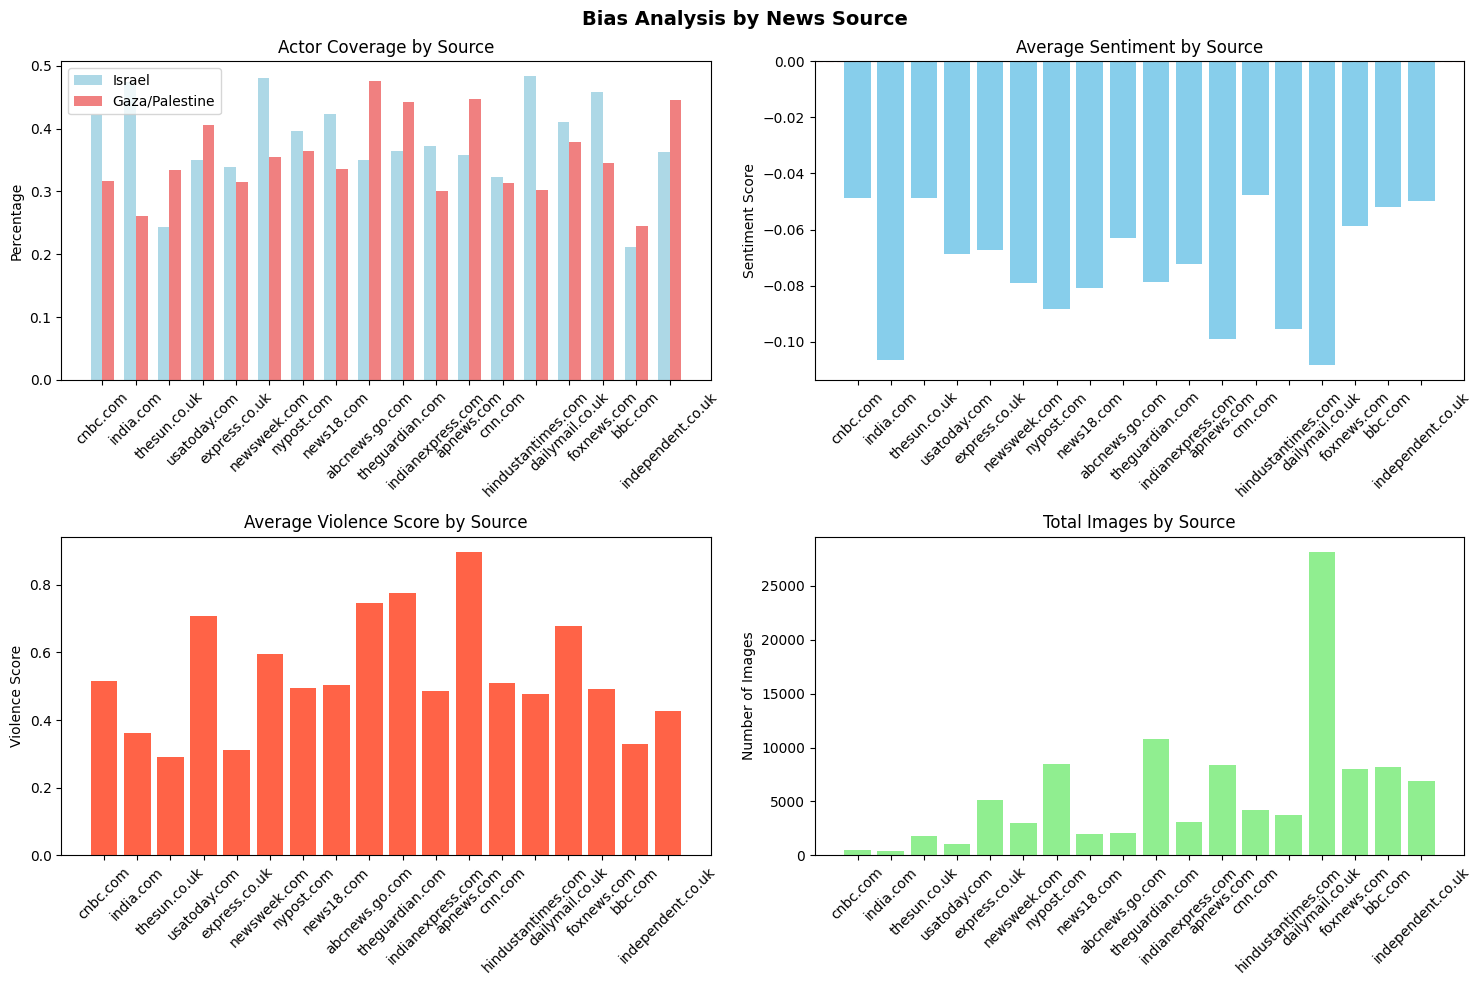


Source Analysis Summary:
--------------------------------------------------

cnbc.com:
  Total images: 517
  Israel coverage: 42.2%
  Palestine coverage: 31.7%
  Avg sentiment: -0.049
  Avg violence:   0.51

india.com:
  Total images: 428
  Israel coverage: 47.4%
  Palestine coverage: 26.2%
  Avg sentiment: -0.107
  Avg violence:   0.36

thesun.co.uk:
  Total images: 1756
  Israel coverage: 24.4%
  Palestine coverage: 33.4%
  Avg sentiment: -0.049
  Avg violence:   0.29

usatoday.com:
  Total images: 1041
  Israel coverage: 35.0%
  Palestine coverage: 40.5%
  Avg sentiment: -0.069
  Avg violence:   0.71

express.co.uk:
  Total images: 5180
  Israel coverage: 33.9%
  Palestine coverage: 31.5%
  Avg sentiment: -0.067
  Avg violence:   0.31

newsweek.com:
  Total images: 3008
  Israel coverage: 48.0%
  Palestine coverage: 35.4%
  Avg sentiment: -0.079
  Avg violence:   0.60

nypost.com:
  Total images: 8477
  Israel coverage: 39.6%
  Palestine coverage: 36.5%
  Avg sentiment: -0.088
  Av

In [27]:
# If you have a 'source' column in your data, analyze bias by news source
if 'source' in df.columns:
    print("Analyzing bias patterns by news source...")
    
    # Create source-based analysis
    source_analysis = {}
    
    for source in df['source'].unique():
        if pd.isna(source):
            continue
            
        source_data = df[df['source'] == source]
        
        if len(source_data) < 5:  # Skip sources with too few images
            continue
        
        # Actor distribution by source
        actor_dist = source_data['primary_actor_enhanced'].value_counts(normalize=True)
        
        # Sentiment by source
        avg_sentiment = source_data['avg_sentiment'].mean()
        
        # Violence indicators by source
        avg_violence = source_data['total_violence_score'].mean()
        
        source_analysis[source] = {
            'total_images': len(source_data),
            'actor_distribution': actor_dist.to_dict(),
            'avg_sentiment': avg_sentiment,
            'avg_violence': avg_violence,
            'israel_percentage': actor_dist.get('Israel', 0),
            'palestine_percentage': actor_dist.get('Gaza/Palestine', 0)
        }
    
    # Create source comparison visualization
    if source_analysis:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Bias Analysis by News Source", fontsize=14, fontweight='bold')
        
        sources = list(source_analysis.keys())
        
        # 1. Coverage distribution by source
        israel_pcts = [source_analysis[s]['israel_percentage'] for s in sources]
        palestine_pcts = [source_analysis[s]['palestine_percentage'] for s in sources]
        
        x = np.arange(len(sources))
        width = 0.35
        
        axes[0, 0].bar(x - width/2, israel_pcts, width, label='Israel', color='lightblue')
        axes[0, 0].bar(x + width/2, palestine_pcts, width, label='Gaza/Palestine', color='lightcoral')
        axes[0, 0].set_title('Actor Coverage by Source')
        axes[0, 0].set_ylabel('Percentage')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(sources, rotation=45)
        axes[0, 0].legend()
        
        # 2. Average sentiment by source
        sentiments = [source_analysis[s]['avg_sentiment'] for s in sources]
        axes[0, 1].bar(sources, sentiments, color='skyblue')
        axes[0, 1].set_title('Average Sentiment by Source')
        axes[0, 1].set_ylabel('Sentiment Score')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
        
        # 3. Average violence score by source
        violence_scores = [source_analysis[s]['avg_violence'] for s in sources]
        axes[1, 0].bar(sources, violence_scores, color='tomato')
        axes[1, 0].set_title('Average Violence Score by Source')
        axes[1, 0].set_ylabel('Violence Score')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # 4. Total images by source
        image_counts = [source_analysis[s]['total_images'] for s in sources]
        axes[1, 1].bar(sources, image_counts, color='lightgreen')
        axes[1, 1].set_title('Total Images by Source')
        axes[1, 1].set_ylabel('Number of Images')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Print source analysis summary
        print("\nSource Analysis Summary:")
        print("-" * 50)
        for source, data in source_analysis.items():
            print(f"\n{source}:")
            print(f"  Total images: {data['total_images']}")
            print(f"  Israel coverage: {data['israel_percentage']:.1%}")
            print(f"  Palestine coverage: {data['palestine_percentage']:.1%}")
            print(f"  Avg sentiment: {data['avg_sentiment']:6.3f}")
            print(f"  Avg violence: {data['avg_violence']:6.2f}")
            
            # Flag potential bias
            if abs(data['israel_percentage'] - data['palestine_percentage']) > 0.4:
                print(f"  ⚠️  Potential coverage bias detected!")
            if abs(data['avg_sentiment']) > 0.2:
                direction = "positive" if data['avg_sentiment'] > 0 else "negative"
                print(f"  ⚠️  Strong {direction} sentiment bias!")

else:
    print("No 'source' column found in data. Skipping source-based analysis.")

In [ ]:
master_index= pd.read_parquet("../data/blip_captioned_images.parquet")
df = df.merge(master_index[['image_id', 'article_id']], on="image_id", how="left", validate="m:1")


,image_id,image_url,caption,blip_caption,actors,patients,scenes,text_for_analysis,primary_actor_enhanced,sentiment_polarity,sentiment_subjectivity,sentiment_vader,avg_sentiment,sentiment_category,violence_indicators,total_violence_score,source,article_id
0,9474f089-1c19-4313-b6c8-1efb21b8681d,https://image.cnbcfm.com/api/v1/image/10731321...,US President Joe Biden addresses the terrorist...,bider is shown in the white house,"[US President Joe Biden, the White House, Pres...","[terrorist, Washington DC, the terrorist attac...","[Washington, DC, DC, ,, State Dining Room of t...",US President Joe Biden addresses the terrorist...,Israel,0.000,0.000,-0.8225,-0.41125,negative,"{'destruction': 0, 'casualties': 0, 'weapons':...",1,cnbc.com,7391326f-e94c-43bf-9e30-268d1b718961
1,b4beed8b-db2b-4785-a27c-a6006be09c51,https://image.cnbcfm.com/api/v1/image/10731318...,Israeli Prime Minister Benjamin Netanyahu (3rd...,a group of people sitting around a table,"[Israeli Prime Minister Benjamin Netanyahu, se...","[Tel Aviv Israel, Israeli Prime Minister Benja...","[Tel Aviv, Israel, Tel, 3rd L]",Israeli Prime Minister Benjamin Netanyahu (3rd...,Israel,0.000,0.000,0.3400,0.17000,positive,"{'destruction': 0, 'casualties': 0, 'weapons':...",0,cnbc.com,4adb82cb-866a-4549-a08a-c69b35a5e31b
2,fd09ee0f-bf29-4c6b-a78e-fe6dd797050c,https://image.cnbcfm.com/api/v1/image/10731316...,Israelis inspect damage caused by a rocket att...,a man standing in front of a pile of junk cars,"[Palestinian militants, Israelis, the Israeli ...","[a rocket attack Gaza, rockets, dozens rockets...",[Gaza],Israelis inspect damage caused by a rocket att...,Gaza/Palestine,0.100,0.650,-0.8720,-0.38600,negative,"{'destruction': 0, 'casualties': 0, 'weapons':...",2,cnbc.com,7b9c28b3-8e98-4445-9be5-b637687c99bc
3,9fe7085d-04a5-4618-81e4-9a1d2f16d1f0,https://image.cnbcfm.com/api/v1/image/10724685...,U.S. Defense Secretary Lloyd Austin speaks dur...,a man in a suit and tie speaking at a podium,"[Mark Milley, U.S. Defense Secretary Lloyd Aus...",[an online meeting the Ukraine Defense Contact...,"[U.S., Pentagon, Washington, the Pentagon]",U.S. Defense Secretary Lloyd Austin speaks dur...,Neutral,0.000,0.100,0.2500,0.12500,positive,"{'destruction': 0, 'casualties': 0, 'weapons':...",0,cnbc.com,f976bdbb-3e6a-4b2e-8941-25b5ae628e8b
4,496d9eda-d99a-4164-9d2e-67c5454acf27,https://image.cnbcfm.com/api/v1/image/10730523...,U.S. Secretary of State Antony Blinken testifi...,a man in a suit and tie sitting at a table,"[Secretary of State, Senate Foreign Relations ...","[Senate Foreign Relations Committee, Washingto...","[U.S., Washington, Antony Blinken]",U.S. Secretary of State Antony Blinken testifi...,Neutral,-0.125,0.125,0.0000,-0.06250,neutral,"{'destruction': 0, 'casualties': 0, 'weapons':...",0,cnbc.com,54e72ff4-fd77-4c7a-a2c1-cc87173475f5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105878,e7d2a8bf-7681-4f51-a092-63035c7b4863,https://static.independent.co.uk/2023/10/07/15...,Hamas launched an unprecedented incursion acro...,a man standing in front of a fire,"[Hamas, firing thousands of rockets in a shock...","[land, sea and air, rockets, Hamas, thousands ...","[Gaza, across the heavily fortified border wit...",Hamas launched an unprecedented incursion acro...,Gaza/Palestine,0.200,0.700,-0.7650,-0.28250,negative,"{'destruction': 0, 'casualties': 0, 'weapons':...",2,independent.co.uk,3cc21845-9e9d-46e3-b771-4730cc69665e
105879,c36dffef-6db1-4af4-9ffc-faa564b94fb8,https://static.independent.co.uk/2023/10/07/20...,Palestinians break into the Israeli side of Is...,a bull bull bull bull bull bull bull bull bull...,"[Reuters, Palestinians break into the Israeli ...","[gunmen infiltrated areas of southern Israel, ...",[Israel - Gaza border fence after gunmen infil...,Palestinians break into the Israeli side of Is...,Israel,0.000,0.000,0.0000,0.00000,neutral,"{'destruction': 0, 'casualties': 0, 'weapons':...",0,independent.co.uk,3cc21845-9e9d-46e3-b771-4730cc6966

In [35]:
article_df=pd.read_parquet("../data/filtered_articles_date_cleaned.parquet")
df = df.merge(article_df[['id', 'publish_date_cleaned']], 
              left_on='article_id', right_on='id', 
              how='left', validate='m:1')
df = df.rename(columns={'publish_date_cleaned': 'date'})
df = df.drop(columns=['id'])
df

,image_id,image_url,caption,blip_caption,actors,patients,scenes,text_for_analysis,primary_actor_enhanced,sentiment_polarity,sentiment_subjectivity,sentiment_vader,avg_sentiment,sentiment_category,violence_indicators,total_violence_score,source,article_id,date
0,9474f089-1c19-4313-b6c8-1efb21b8681d,https://image.cnbcfm.com/api/v1/image/10731321...,US President Joe Biden addresses the terrorist...,bider is shown in the white house,"[US President Joe Biden, the White House, Pres...","[terrorist, Washington DC, the terrorist attac...","[Washington, DC, DC, ,, State Dining Room of t...",US President Joe Biden addresses the terrorist...,Israel,0.000,0.000,-0.8225,-0.41125,negative,"{'destruction': 0, 'casualties': 0, 'weapons':...",1,cnbc.com,7391326f-e94c-43bf-9e30-268d1b718961,2023-10-07 16:23:27
1,b4beed8b-db2b-4785-a27c-a6006be09c51,https://image.cnbcfm.com/api/v1/image/10731318...,Israeli Prime Minister Benjamin Netanyahu (3rd...,a group of people sitting around a table,"[Israeli Prime Minister Benjamin Netanyahu, se...","[Tel Aviv Israel, Israeli Prime Minister Benja...","[Tel Aviv, Israel, Tel, 3rd L]",Israeli Prime Minister Benjamin Netanyahu (3rd...,Israel,0.000,0.000,0.3400,0.17000,positive,"{'destruction': 0, 'casualties': 0, 'weapons':...",0,cnbc.com,4adb82cb-866a-4549-a08a-c69b35a5e31b,2023-10-08 07:48:54
2,fd09ee0f-bf29-4c6b-a78e-fe6dd797050c,https://image.cnbcfm.com/api/v1/image/10731316...,Israelis inspect damage caused by a rocket att...,a man standing in front of a pile of junk cars,"[Palestinian militants, Israelis, the Israeli ...","[a rocket attack Gaza, rockets, dozens rockets...",[Gaza],Israelis inspect damage caused by a rocket att...,Gaza/Palestine,0.100,0.650,-0.8720,-0.38600,negative,"{'destruction': 0, 'casualties': 0, 'weapons':...",2,cnbc.com,7b9c28b3-8e98-4445-9be5-b637687c99bc,2023-10-07 06:57:36
3,9fe7085d-04a5-4618-81e4-9a1d2f16d1f0,https://image.cnbcfm.com/api/v1/image/10724685...,U.S. Defense Secretary Lloyd Austin speaks dur...,a man in a suit and tie speaking at a podium,"[Mark Milley, U.S. Defense Secretary Lloyd Aus...",[an online meeting the Ukraine Defense Contact...,"[U.S., Pentagon, Washington, the Pentagon]",U.S. Defense Secretary Lloyd Austin speaks dur...,Neutral,0.000,0.100,0.2500,0.12500,positive,"{'destruction': 0, 'casualties': 0, 'weapons':...",0,cnbc.com,f976bdbb-3e6a-4b2e-8941-25b5ae628e8b,2023-10-08 18:39:35
4,496d9eda-d99a-4164-9d2e-67c5454acf27,https://image.cnbcfm.com/api/v1/image/10730523...,U.S. Secretary of State Antony Blinken testifi...,a man in a suit and tie sitting at a table,"[Secretary of State, Senate Foreign Relations ...","[Senate Foreign Relations Committee, Washingto...","[U.S., Washington, Antony Blinken]",U.S. Secretary of State Antony Blinken testifi...,Neutral,-0.125,0.125,0.0000,-0.06250,neutral,"{'destruction': 0, 'casualties': 0, 'weapons':...",0,cnbc.com,54e72ff4-fd77-4c7a-a2c1-cc87173475f5,2023-10-08 16:09:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105878,e7d2a8bf-7681-4f51-a092-63035c7b4863,https://static.independent.co.uk/2023/10/07/15...,Hamas launched an unprecedented incursion acro...,a man standing in front of a fire,"[Hamas, firing thousands of rockets in a shock...","[land, sea and air, rockets, Hamas, thousands ...","[Gaza, across the heavily fortified border wit...",Hamas launched an unprecedented incursion acro...,Gaza/Palestine,0.200,0.700,-0.7650,-0.28250,negative,"{'destruction': 0, 'casualties': 0, 'weapons':...",2,independent.co.uk,3cc21845-9e9d-46e3-b771-4730cc69665e,2023-10-08 06:38:00
105879,c36dffef-6db1-4af4-9ffc-faa564b94fb8,https://static.independent.co.uk/2023/10/07/20...,Palestinians break into the Israeli side of Is...,a bull bull bull bull bull bull bull bull bull...,"[Reuters, Palestinians break into the Israeli ...","[gunmen infiltrated areas of southern Israel, ...",[Israel - Gaza border fence after gunmen infil...,Palestinians break into the Israeli side of Is...,Israel,0.000,0.000,

Performing temporal bias analysis...


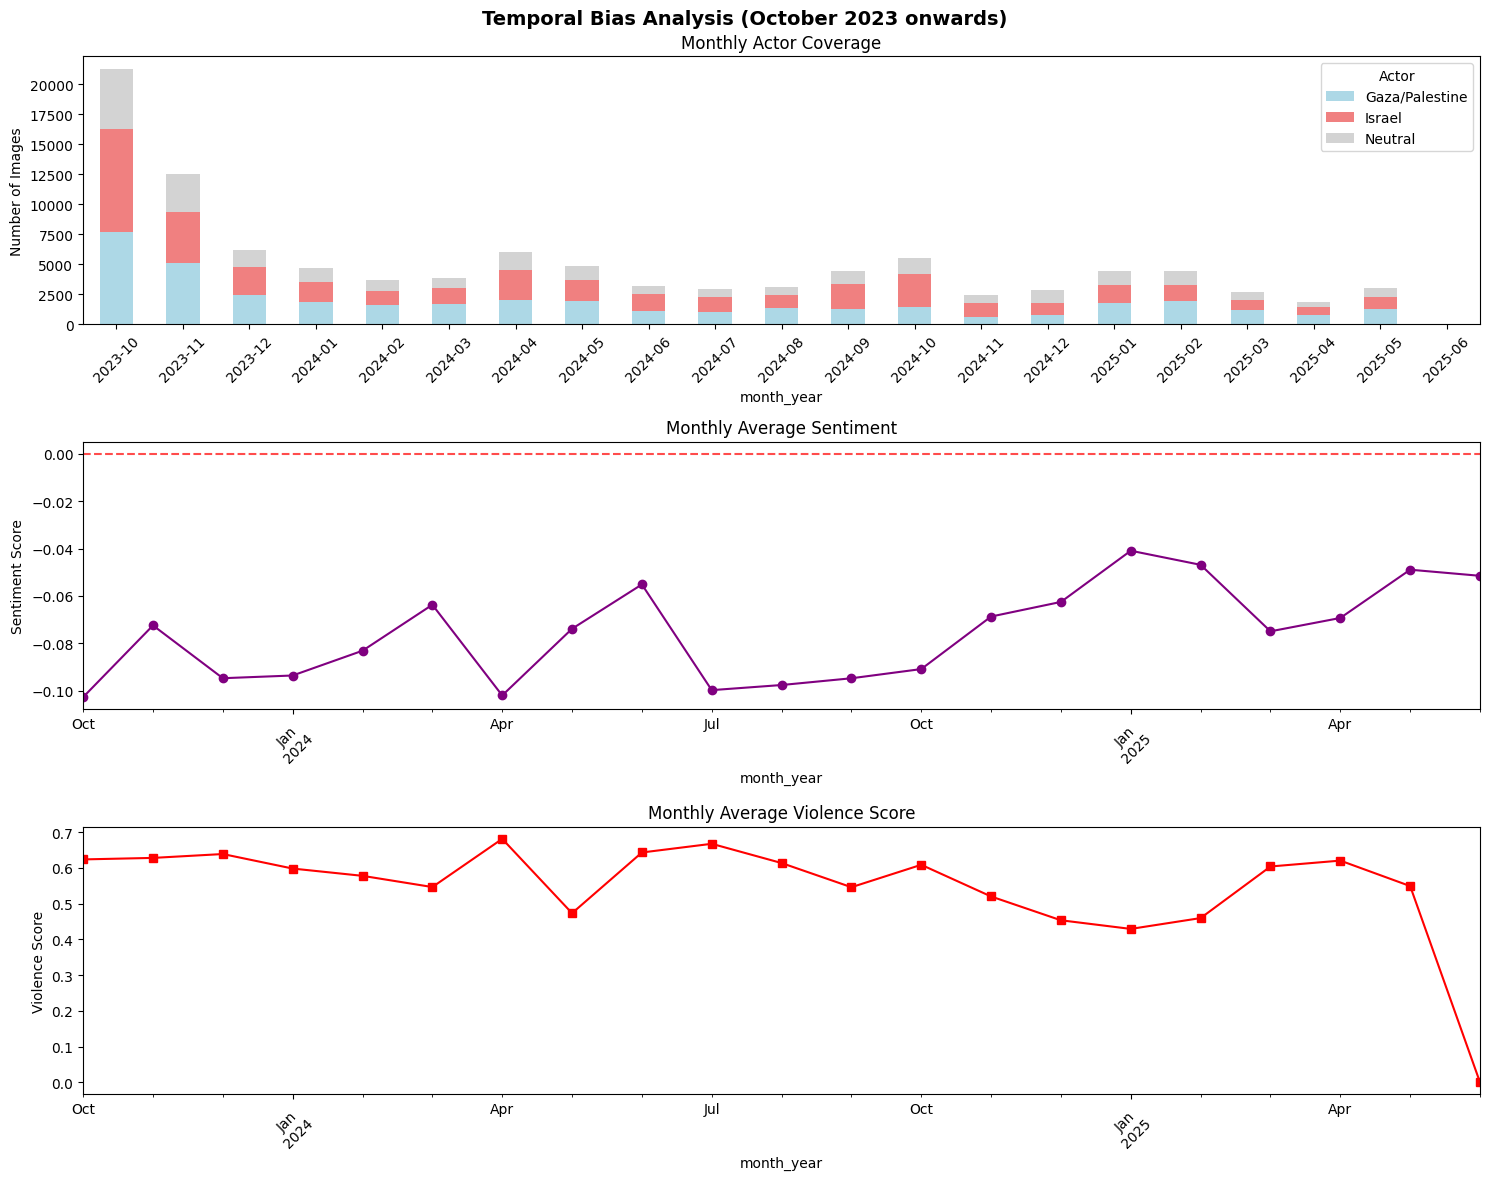

Temporal analysis complete for 103891 images with valid dates from October 2023 onwards

Months with highest coverage imbalance:
  2025-06: 0.538 imbalance
  2024-11: 0.244 imbalance
  2024-10: 0.243 imbalance


In [37]:
# If you have date/time information, analyze temporal patterns
if 'date' in df.columns or 'timestamp' in df.columns:
    date_col = 'date' if 'date' in df.columns else 'timestamp'
    
    print("Performing temporal bias analysis...")
    
    # Convert to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    # Remove rows with invalid dates and filter from October 2023 onwards
    df_temporal = df.dropna(subset=[date_col]).copy()
    df_temporal = df_temporal[df_temporal[date_col] >= '2023-10-01']
    
    if len(df_temporal) > 0:
        # Create time-based groupings
        df_temporal['month_year'] = df_temporal[date_col].dt.to_period('M')
        
        # Analyze monthly trends
        monthly_trends = df_temporal.groupby(['month_year', 'primary_actor_enhanced']).size().unstack(fill_value=0)
        monthly_sentiment = df_temporal.groupby('month_year')['avg_sentiment'].mean()
        monthly_violence = df_temporal.groupby('month_year')['total_violence_score'].mean()
        
        # Create temporal visualizations
        fig, axes = plt.subplots(3, 1, figsize=(15, 12))
        fig.suptitle('Temporal Bias Analysis (October 2023 onwards)', fontsize=14, fontweight='bold')
        
        # 1. Monthly actor coverage
        monthly_trends.plot(kind='bar', stacked=True, ax=axes[0], 
                           color=['lightblue', 'lightcoral', 'lightgray'])
        axes[0].set_title('Monthly Actor Coverage')
        axes[0].set_ylabel('Number of Images')
        axes[0].legend(title='Actor')
        axes[0].tick_params(axis='x', rotation=45)
        
        # 2. Monthly sentiment trend
        monthly_sentiment.plot(ax=axes[1], marker='o', color='purple')
        axes[1].set_title('Monthly Average Sentiment')
        axes[1].set_ylabel('Sentiment Score')
        axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
        axes[1].tick_params(axis='x', rotation=45)
        
        # 3. Monthly violence trend
        monthly_violence.plot(ax=axes[2], marker='s', color='red')
        axes[2].set_title('Monthly Average Violence Score')
        axes[2].set_ylabel('Violence Score')
        axes[2].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Temporal analysis complete for {len(df_temporal)} images with valid dates from October 2023 onwards")
        
        # Find periods with highest bias
        if len(monthly_trends) > 1:
            # Calculate monthly bias metrics
            monthly_bias = pd.DataFrame({
                'israel_pct': monthly_trends.get('Israel', 0) / monthly_trends.sum(axis=1),
                'palestine_pct': monthly_trends.get('Gaza/Palestine', 0) / monthly_trends.sum(axis=1),
                'sentiment': monthly_sentiment,
                'violence': monthly_violence
            })
            
            monthly_bias['coverage_imbalance'] = abs(monthly_bias['israel_pct'] - monthly_bias['palestine_pct'])
            
            print("\nMonths with highest coverage imbalance:")
            top_imbalanced = monthly_bias.nlargest(3, 'coverage_imbalance')
            for period, row in top_imbalanced.iterrows():
                print(f"  {period}: {row['coverage_imbalance']:.3f} imbalance")
    
else:
    print("No date/timestamp column found. Skipping temporal analysis.")

In [38]:
print("="*80)
print("FINAL INSIGHTS AND RECOMMENDATIONS")
print("="*80)

# Calculate key metrics for final summary
total_images = len(df)
israel_images = len(df[df['primary_actor_enhanced'] == 'Israel'])
palestine_images = len(df[df['primary_actor_enhanced'] == 'Gaza/Palestine'])
neutral_images = len(df[df['primary_actor_enhanced'] == 'Neutral'])

israel_sentiment = df[df['primary_actor_enhanced'] == 'Israel']['avg_sentiment'].mean()
palestine_sentiment = df[df['primary_actor_enhanced'] == 'Gaza/Palestine']['avg_sentiment'].mean()

israel_violence = df[df['primary_actor_enhanced'] == 'Israel']['total_violence_score'].mean()
palestine_violence = df[df['primary_actor_enhanced'] == 'Gaza/Palestine']['total_violence_score'].mean()

print(f"\n📊 DATASET OVERVIEW:")
print(f"   Total images analyzed: {total_images:,}")
print(f"   Israel-focused: {israel_images:,} ({israel_images/total_images:.1%})")
print(f"   Palestine-focused: {palestine_images:,} ({palestine_images/total_images:.1%})")
print(f"   Neutral/Other: {neutral_images:,} ({neutral_images/total_images:.1%})")

print(f"\n🎭 SENTIMENT ANALYSIS:")
print(f"   Israel avg sentiment: {israel_sentiment:6.3f}")
print(f"   Palestine avg sentiment: {palestine_sentiment:6.3f}")
print(f"   Sentiment difference: {israel_sentiment - palestine_sentiment:6.3f}")

if abs(israel_sentiment - palestine_sentiment) > 0.15:
    bias_direction = "pro-Israel" if israel_sentiment > palestine_sentiment else "pro-Palestine"
    print(f"   ⚠️  SIGNIFICANT SENTIMENT BIAS DETECTED ({bias_direction})")
else:
    print(f"   ✅ Sentiment appears relatively balanced")

print(f"\n⚔️  VIOLENCE FRAMING:")
print(f"   Israel avg violence score: {israel_violence:6.2f}")
print(f"   Palestine avg violence score: {palestine_violence:6.2f}")
print(f"   Violence difference: {israel_violence - palestine_violence:6.2f}")

if abs(israel_violence - palestine_violence) > 1.0:
    print(f"   ⚠️  SIGNIFICANT VIOLENCE FRAMING BIAS DETECTED")
else:
    print(f"   ✅ Violence framing appears relatively balanced")

print(f"\n📈 COVERAGE ANALYSIS:")
coverage_imbalance = abs(israel_images - palestine_images) / (israel_images + palestine_images) if (israel_images + palestine_images) > 0 else 0
print(f"   Coverage imbalance: {coverage_imbalance:.3f}")

if coverage_imbalance > 0.3:
    dominant_actor = "Israel" if israel_images > palestine_images else "Palestine"
    print(f"   ⚠️  SIGNIFICANT COVERAGE BIAS DETECTED (favoring {dominant_actor})")
else:
    print(f"   ✅ Coverage appears relatively balanced")

print(f"\n🔍 KEY FINDINGS:")

# Identify the most problematic areas
issues = []
if abs(israel_sentiment - palestine_sentiment) > 0.15:
    issues.append("sentiment disparity")
if coverage_imbalance > 0.3:
    issues.append("coverage imbalance")
if abs(israel_violence - palestine_violence) > 1.0:
    issues.append("violence framing bias")

if issues:
    print(f"   • Primary bias concerns: {', '.join(issues)}")
else:
    print(f"   • No major bias indicators detected")

# Most common violence categories
most_violent_category = max(violence_by_category.items(), key=lambda x: x[1])
print(f"   • Most common violence indicator: '{most_violent_category[0]}' ({most_violent_category[1]} mentions)")

# Sentiment distribution
negative_pct = (df['sentiment_category'] == 'negative').mean()
positive_pct = (df['sentiment_category'] == 'positive').mean()
print(f"   • Overall tone: {negative_pct:.1%} negative, {positive_pct:.1%} positive")

print(f"\n💡 RECOMMENDATIONS:")
print(f"   1. Monitor coverage balance between actors")
print(f"   2. Review sentiment patterns in captions and descriptions")
print(f"   3. Analyze violence terminology usage")
print(f"   4. Consider editorial guidelines for balanced reporting")
print(f"   5. Regular bias audits using this framework")

if 'source' in df.columns:
    print(f"   6. Implement source-specific bias monitoring")
    
print(f"\n📝 METHODOLOGY NOTES:")
print(f"   • Analysis based on {total_images:,} news images")
print(f"   • Used SRL (Semantic Role Labeling) for entity extraction")
print(f"   • Combined TextBlob and VADER for sentiment analysis")
print(f"   • Violence indicators across 6 categories")
print(f"   • Bias threshold: 0.15 for sentiment, 0.3 for coverage")

print("="*80)
print("Analysis complete! Check saved files for detailed results.")
print("="*80)

FINAL INSIGHTS AND RECOMMENDATIONS

📊 DATASET OVERVIEW:
   Total images analyzed: 105,883
   Israel-focused: 40,052 (37.8%)
   Palestine-focused: 39,115 (36.9%)
   Neutral/Other: 26,716 (25.2%)

🎭 SENTIMENT ANALYSIS:
   Israel avg sentiment: -0.108
   Palestine avg sentiment: -0.097
   Sentiment difference: -0.012
   ✅ Sentiment appears relatively balanced

⚔️  VIOLENCE FRAMING:
   Israel avg violence score:   0.65
   Palestine avg violence score:   0.72
   Violence difference:  -0.07
   ✅ Violence framing appears relatively balanced

📈 COVERAGE ANALYSIS:
   Coverage imbalance: 0.012
   ✅ Coverage appears relatively balanced

🔍 KEY FINDINGS:
   • No major bias indicators detected
   • Most common violence indicator: 'conflict' (16451 mentions)
   • Overall tone: 40.3% negative, 16.5% positive

💡 RECOMMENDATIONS:
   1. Monitor coverage balance between actors
   2. Review sentiment patterns in captions and descriptions
   3. Analyze violence terminology usage
   4. Consider editorial gui

FINAL INSIGHTS AND RECOMMENDATIONS

📊 DATASET OVERVIEW:
   Total images analyzed: 105,883
   Israel-focused: 40,052 (37.8%)
   Palestine-focused: 39,115 (36.9%)
   Neutral/Other: 26,716 (25.2%)

🎭 SENTIMENT ANALYSIS:
   Israel avg sentiment: -0.108
   Palestine avg sentiment: -0.097
   Sentiment difference: -0.012
   ✅ Sentiment appears relatively balanced

⚔️  VIOLENCE FRAMING:
   Israel avg violence score:   0.65
   Palestine avg violence score:   0.72
   Violence difference:  -0.07
   ✅ Violence framing appears relatively balanced

📈 COVERAGE ANALYSIS:
   Coverage imbalance: 0.012
   ✅ Coverage appears relatively balanced

📰 SOURCE-WISE BIAS ANALYSIS:
   Analyzing 18 sources with ≥10 images each

🚨 SOURCES WITH POTENTIAL BIAS (2+ indicators):
   ✅ No sources show multiple bias indicators

📊 ALL SOURCES SUMMARY:
Source               Images   Israel%  Palestine% CovBias  SentBias  ViolBias  Flags          
-------------------------------------------------------------------------------

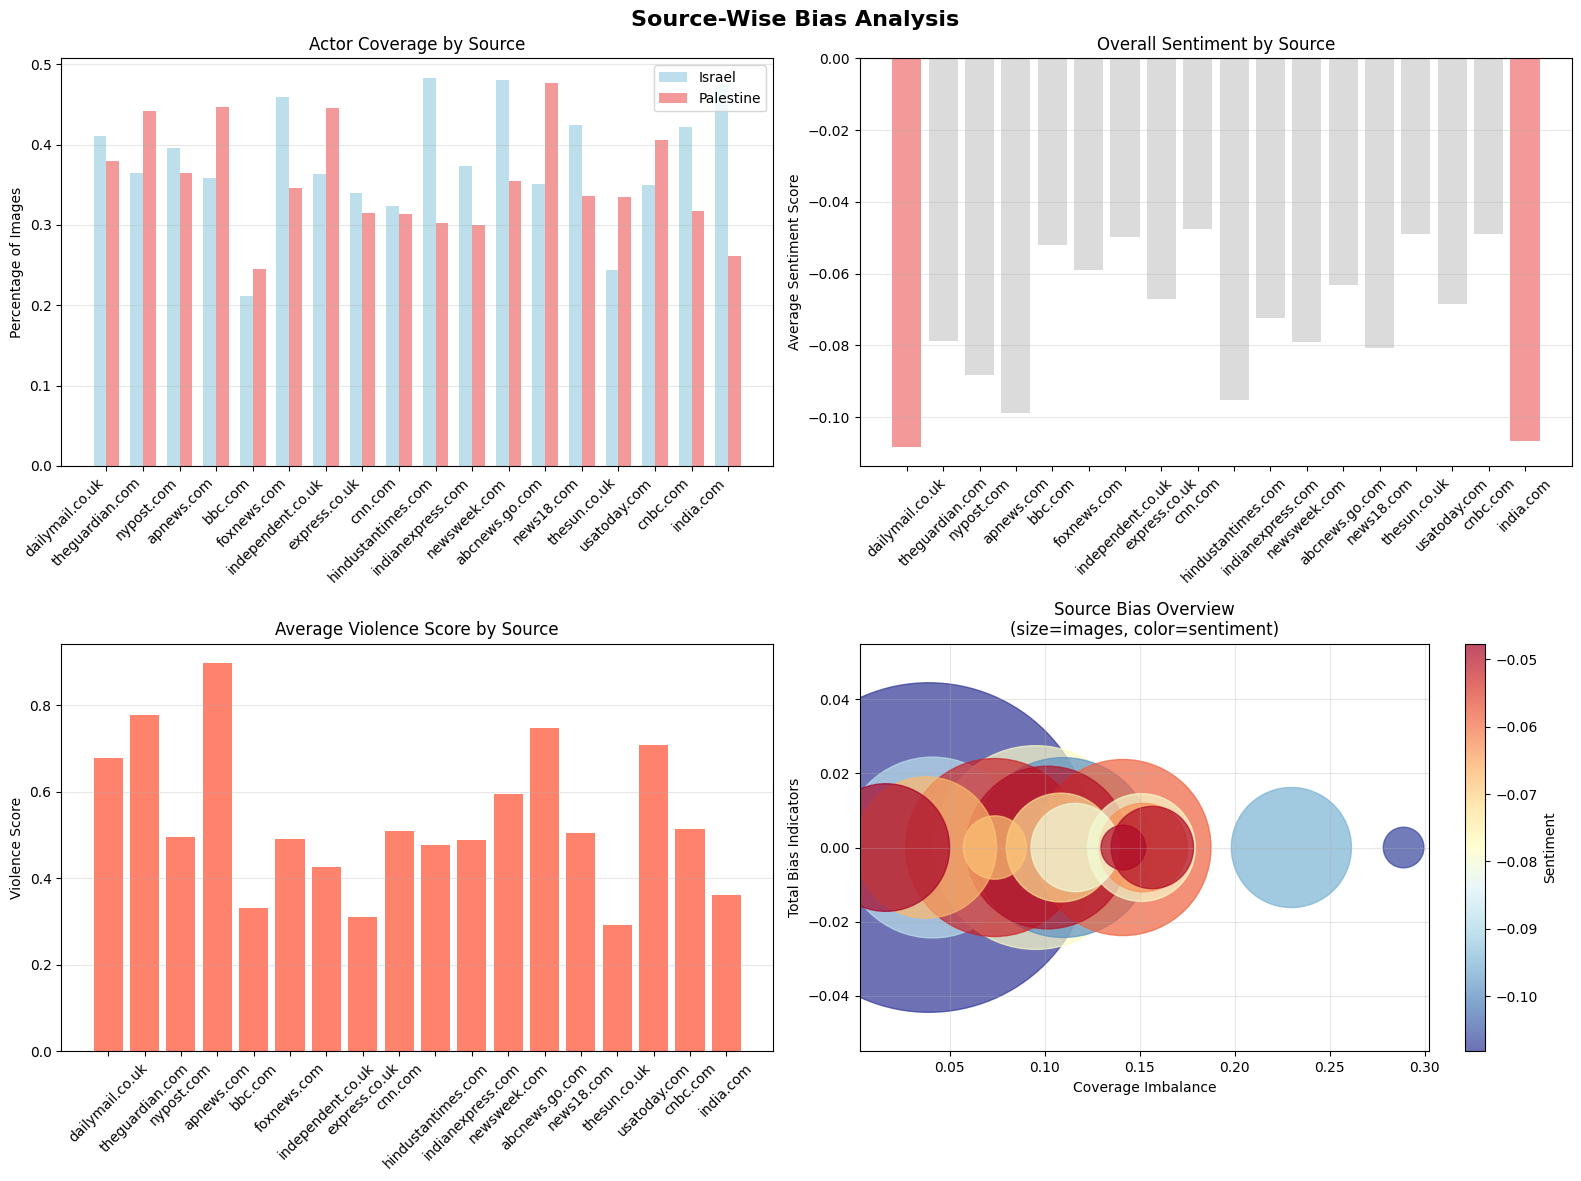


🔍 KEY FINDINGS:
   • No major bias indicators detected
   • Most common violence indicator: 'conflict' (16451 mentions)
   • Overall tone: 40.3% negative, 16.5% positive

💡 RECOMMENDATIONS:
   1. Monitor coverage balance between actors
   2. Review sentiment patterns in captions and descriptions
   3. Analyze violence terminology usage
   4. Consider editorial guidelines for balanced reporting
   5. Regular bias audits using this framework
   6. Implement source-specific bias monitoring
   7. Focus on 0 sources showing multiple bias indicators
   8. Use balanced sources as models for editorial guidelines

📝 METHODOLOGY NOTES:
   • Analysis based on 105,883 news images
   • Used SRL (Semantic Role Labeling) for entity extraction
   • Combined TextBlob and VADER for sentiment analysis
   • Violence indicators across 6 categories
   • Bias thresholds: 0.15 for sentiment, 0.3 for coverage
   • Source analysis: minimum 10 images per source
   • Source bias flags: coverage >0.4, sentiment >

In [39]:
print("="*80)
print("FINAL INSIGHTS AND RECOMMENDATIONS")
print("="*80)

# Calculate key metrics for final summary
total_images = len(df)
israel_images = len(df[df['primary_actor_enhanced'] == 'Israel'])
palestine_images = len(df[df['primary_actor_enhanced'] == 'Gaza/Palestine'])
neutral_images = len(df[df['primary_actor_enhanced'] == 'Neutral'])

israel_sentiment = df[df['primary_actor_enhanced'] == 'Israel']['avg_sentiment'].mean()
palestine_sentiment = df[df['primary_actor_enhanced'] == 'Gaza/Palestine']['avg_sentiment'].mean()

israel_violence = df[df['primary_actor_enhanced'] == 'Israel']['total_violence_score'].mean()
palestine_violence = df[df['primary_actor_enhanced'] == 'Gaza/Palestine']['total_violence_score'].mean()

print(f"\n📊 DATASET OVERVIEW:")
print(f"   Total images analyzed: {total_images:,}")
print(f"   Israel-focused: {israel_images:,} ({israel_images/total_images:.1%})")
print(f"   Palestine-focused: {palestine_images:,} ({palestine_images/total_images:.1%})")
print(f"   Neutral/Other: {neutral_images:,} ({neutral_images/total_images:.1%})")

print(f"\n🎭 SENTIMENT ANALYSIS:")
print(f"   Israel avg sentiment: {israel_sentiment:6.3f}")
print(f"   Palestine avg sentiment: {palestine_sentiment:6.3f}")
print(f"   Sentiment difference: {israel_sentiment - palestine_sentiment:6.3f}")

if abs(israel_sentiment - palestine_sentiment) > 0.15:
    bias_direction = "pro-Israel" if israel_sentiment > palestine_sentiment else "pro-Palestine"
    print(f"   ⚠️  SIGNIFICANT SENTIMENT BIAS DETECTED ({bias_direction})")
else:
    print(f"   ✅ Sentiment appears relatively balanced")

print(f"\n⚔️  VIOLENCE FRAMING:")
print(f"   Israel avg violence score: {israel_violence:6.2f}")
print(f"   Palestine avg violence score: {palestine_violence:6.2f}")
print(f"   Violence difference: {israel_violence - palestine_violence:6.2f}")

if abs(israel_violence - palestine_violence) > 1.0:
    print(f"   ⚠️  SIGNIFICANT VIOLENCE FRAMING BIAS DETECTED")
else:
    print(f"   ✅ Violence framing appears relatively balanced")

print(f"\n📈 COVERAGE ANALYSIS:")
coverage_imbalance = abs(israel_images - palestine_images) / (israel_images + palestine_images) if (israel_images + palestine_images) > 0 else 0
print(f"   Coverage imbalance: {coverage_imbalance:.3f}")

if coverage_imbalance > 0.3:
    dominant_actor = "Israel" if israel_images > palestine_images else "Palestine"
    print(f"   ⚠️  SIGNIFICANT COVERAGE BIAS DETECTED (favoring {dominant_actor})")
else:
    print(f"   ✅ Coverage appears relatively balanced")

# ============================================================================
# SOURCE-WISE BIAS ANALYSIS
# ============================================================================

if 'source' in df.columns:
    print(f"\n📰 SOURCE-WISE BIAS ANALYSIS:")
    print("="*50)
    
    # Get sources with sufficient data (minimum 10 images)
    source_counts = df['source'].value_counts()
    significant_sources = source_counts[source_counts >= 10].index.tolist()
    
    if len(significant_sources) == 0:
        print("   ⚠️  No sources with sufficient data (min 10 images) for bias analysis")
    else:
        print(f"   Analyzing {len(significant_sources)} sources with ≥10 images each")
        
        # Initialize source bias tracking
        source_bias_summary = []
        highly_biased_sources = []
        
        for source in significant_sources:
            source_data = df[df['source'] == source]
            source_total = len(source_data)
            
            # Actor distribution
            source_israel = len(source_data[source_data['primary_actor_enhanced'] == 'Israel'])
            source_palestine = len(source_data[source_data['primary_actor_enhanced'] == 'Gaza/Palestine'])
            source_neutral = len(source_data[source_data['primary_actor_enhanced'] == 'Neutral'])
            
            # Coverage percentages
            israel_pct = source_israel / source_total
            palestine_pct = source_palestine / source_total
            neutral_pct = source_neutral / source_total
            
            # Coverage imbalance (only if both actors are present)
            if source_israel + source_palestine > 0:
                source_coverage_imbalance = abs(source_israel - source_palestine) / (source_israel + source_palestine)
            else:
                source_coverage_imbalance = 0
            
            # Sentiment analysis
            source_israel_sentiment = source_data[source_data['primary_actor_enhanced'] == 'Israel']['avg_sentiment'].mean()
            source_palestine_sentiment = source_data[source_data['primary_actor_enhanced'] == 'Gaza/Palestine']['avg_sentiment'].mean()
            source_overall_sentiment = source_data['avg_sentiment'].mean()
            
            # Violence analysis
            source_israel_violence = source_data[source_data['primary_actor_enhanced'] == 'Israel']['total_violence_score'].mean()
            source_palestine_violence = source_data[source_data['primary_actor_enhanced'] == 'Gaza/Palestine']['total_violence_score'].mean()
            source_overall_violence = source_data['total_violence_score'].mean()
            
            # Calculate bias scores
            sentiment_bias = abs(source_israel_sentiment - source_palestine_sentiment) if not (pd.isna(source_israel_sentiment) or pd.isna(source_palestine_sentiment)) else 0
            violence_bias = abs(source_israel_violence - source_palestine_violence) if not (pd.isna(source_israel_violence) or pd.isna(source_palestine_violence)) else 0
            
            # Bias flags
            bias_flags = []
            if source_coverage_imbalance > 0.4:
                bias_flags.append("COVERAGE")
            if sentiment_bias > 0.2:
                bias_flags.append("SENTIMENT")
            if violence_bias > 1.5:
                bias_flags.append("VIOLENCE")
            if abs(source_overall_sentiment) > 0.25:
                bias_flags.append("OVERALL_TONE")
            
            # Store source analysis
            source_analysis = {
                'source': source,
                'total_images': source_total,
                'israel_pct': israel_pct,
                'palestine_pct': palestine_pct,
                'neutral_pct': neutral_pct,
                'coverage_imbalance': source_coverage_imbalance,
                'israel_sentiment': source_israel_sentiment,
                'palestine_sentiment': source_palestine_sentiment,
                'overall_sentiment': source_overall_sentiment,
                'sentiment_bias': sentiment_bias,
                'israel_violence': source_israel_violence,
                'palestine_violence': source_palestine_violence,
                'overall_violence': source_overall_violence,
                'violence_bias': violence_bias,
                'bias_flags': bias_flags,
                'bias_score': len(bias_flags)
            }
            
            source_bias_summary.append(source_analysis)
            
            if len(bias_flags) >= 2:  # Sources with 2+ bias indicators
                highly_biased_sources.append(source_analysis)
        
        # Sort sources by bias score (descending)
        source_bias_summary.sort(key=lambda x: x['bias_score'], reverse=True)
        
        print(f"\n🚨 SOURCES WITH POTENTIAL BIAS (2+ indicators):")
        if len(highly_biased_sources) == 0:
            print("   ✅ No sources show multiple bias indicators")
        else:
            for source_info in highly_biased_sources:
                print(f"\n   📰 {source_info['source']} (n={source_info['total_images']}):")
                print(f"      • Coverage: Israel {source_info['israel_pct']:.1%}, Palestine {source_info['palestine_pct']:.1%}")
                print(f"      • Coverage imbalance: {source_info['coverage_imbalance']:.3f}")
                print(f"      • Sentiment bias: {source_info['sentiment_bias']:.3f}")
                print(f"      • Violence bias: {source_info['violence_bias']:.3f}")
                print(f"      • Overall tone: {source_info['overall_sentiment']:.3f}")
                print(f"      • Bias flags: {', '.join(source_info['bias_flags'])}")
        
        print(f"\n📊 ALL SOURCES SUMMARY:")
        print(f"{'Source':<20} {'Images':<8} {'Israel%':<8} {'Palestine%':<10} {'CovBias':<8} {'SentBias':<9} {'ViolBias':<9} {'Flags':<15}")
        print("-" * 95)
        
        for source_info in source_bias_summary:
            flags_str = ','.join(source_info['bias_flags'][:2]) if source_info['bias_flags'] else 'None'
            if len(flags_str) > 14:
                flags_str = flags_str[:11] + '...'
            
            print(f"{source_info['source']:<20} "
                  f"{source_info['total_images']:<8} "
                  f"{source_info['israel_pct']:<8.1%} "
                  f"{source_info['palestine_pct']:<10.1%} "
                  f"{source_info['coverage_imbalance']:<8.3f} "
                  f"{source_info['sentiment_bias']:<9.3f} "
                  f"{source_info['violence_bias']:<9.3f} "
                  f"{flags_str:<15}")
        
        # Source-specific recommendations
        print(f"\n🎯 SOURCE-SPECIFIC RECOMMENDATIONS:")
        
        # Most balanced sources
        balanced_sources = [s for s in source_bias_summary if s['bias_score'] == 0]
        if balanced_sources:
            print(f"   ✅ Most balanced sources: {', '.join([s['source'] for s in balanced_sources[:3]])}")
        
        # Most biased sources
        most_biased = source_bias_summary[:3]  # Top 3 most biased
        if most_biased[0]['bias_score'] > 0:
            print(f"   ⚠️  Sources needing attention: {', '.join([s['source'] for s in most_biased if s['bias_score'] > 0])}")
        
        # Coverage patterns
        israel_heavy_sources = [s for s in source_bias_summary if s['israel_pct'] > 0.6 and s['palestine_pct'] < 0.2]
        palestine_heavy_sources = [s for s in source_bias_summary if s['palestine_pct'] > 0.6 and s['israel_pct'] < 0.2]
        
        if israel_heavy_sources:
            print(f"   📊 Israel-heavy coverage: {', '.join([s['source'] for s in israel_heavy_sources])}")
        if palestine_heavy_sources:
            print(f"   📊 Palestine-heavy coverage: {', '.join([s['source'] for s in palestine_heavy_sources])}")
        
        # Create source bias visualization
        if len(source_bias_summary) > 1:
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('Source-Wise Bias Analysis', fontsize=16, fontweight='bold')
            
            # 1. Coverage distribution by source
            sources = [s['source'] for s in source_bias_summary]
            israel_pcts = [s['israel_pct'] for s in source_bias_summary]
            palestine_pcts = [s['palestine_pct'] for s in source_bias_summary]
            
            x = np.arange(len(sources))
            width = 0.35
            
            axes[0, 0].bar(x - width/2, israel_pcts, width, label='Israel', color='lightblue', alpha=0.8)
            axes[0, 0].bar(x + width/2, palestine_pcts, width, label='Palestine', color='lightcoral', alpha=0.8)
            axes[0, 0].set_title('Actor Coverage by Source')
            axes[0, 0].set_ylabel('Percentage of Images')
            axes[0, 0].set_xticks(x)
            axes[0, 0].set_xticklabels(sources, rotation=45, ha='right')
            axes[0, 0].legend()
            axes[0, 0].grid(axis='y', alpha=0.3)
            
            # 2. Overall sentiment by source
            overall_sentiments = [s['overall_sentiment'] for s in source_bias_summary]
            colors = ['lightgreen' if s > 0.1 else 'lightcoral' if s < -0.1 else 'lightgray' for s in overall_sentiments]
            
            axes[0, 1].bar(sources, overall_sentiments, color=colors, alpha=0.8)
            axes[0, 1].set_title('Overall Sentiment by Source')
            axes[0, 1].set_ylabel('Average Sentiment Score')
            axes[0, 1].tick_params(axis='x', rotation=45)
            axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
            axes[0, 1].grid(axis='y', alpha=0.3)
            
            # 3. Violence scores by source
            overall_violence = [s['overall_violence'] for s in source_bias_summary]
            axes[1, 0].bar(sources, overall_violence, color='tomato', alpha=0.8)
            axes[1, 0].set_title('Average Violence Score by Source')
            axes[1, 0].set_ylabel('Violence Score')
            axes[1, 0].tick_params(axis='x', rotation=45)
            axes[1, 0].grid(axis='y', alpha=0.3)
            
            # 4. Bias score heatmap
            bias_scores = [s['bias_score'] for s in source_bias_summary]
            coverage_imbalances = [s['coverage_imbalance'] for s in source_bias_summary]
            
            scatter = axes[1, 1].scatter(coverage_imbalances, bias_scores, 
                                       s=[s['total_images']*2 for s in source_bias_summary],
                                       c=overall_sentiments, cmap='RdYlBu_r', alpha=0.7)
            axes[1, 1].set_xlabel('Coverage Imbalance')
            axes[1, 1].set_ylabel('Total Bias Indicators')
            axes[1, 1].set_title('Source Bias Overview\n(size=images, color=sentiment)')
            
            # Add source labels for highly biased sources
            for i, source_info in enumerate(source_bias_summary):
                if source_info['bias_score'] >= 2:
                    axes[1, 1].annotate(source_info['source'], 
                                      (source_info['coverage_imbalance'], source_info['bias_score']),
                                      xytext=(5, 5), textcoords='offset points', fontsize=8)
            
            plt.colorbar(scatter, ax=axes[1, 1], label='Sentiment')
            axes[1, 1].grid(alpha=0.3)
            
            plt.tight_layout()
            plt.show()

else:
    print(f"\n📰 SOURCE ANALYSIS:")
    print("   ⚠️  No 'source' column found in data - skipping source-wise analysis")

# ============================================================================
# OVERALL SUMMARY AND KEY FINDINGS
# ============================================================================

print(f"\n🔍 KEY FINDINGS:")

# Identify the most problematic areas
issues = []
if abs(israel_sentiment - palestine_sentiment) > 0.15:
    issues.append("sentiment disparity")
if coverage_imbalance > 0.3:
    issues.append("coverage imbalance")
if abs(israel_violence - palestine_violence) > 1.0:
    issues.append("violence framing bias")

if issues:
    print(f"   • Primary bias concerns: {', '.join(issues)}")
else:
    print(f"   • No major bias indicators detected")

# Most common violence categories
most_violent_category = max(violence_by_category.items(), key=lambda x: x[1])
print(f"   • Most common violence indicator: '{most_violent_category[0]}' ({most_violent_category[1]} mentions)")

# Sentiment distribution
negative_pct = (df['sentiment_category'] == 'negative').mean()
positive_pct = (df['sentiment_category'] == 'positive').mean()
print(f"   • Overall tone: {negative_pct:.1%} negative, {positive_pct:.1%} positive")

print(f"\n💡 RECOMMENDATIONS:")
print(f"   1. Monitor coverage balance between actors")
print(f"   2. Review sentiment patterns in captions and descriptions")
print(f"   3. Analyze violence terminology usage")
print(f"   4. Consider editorial guidelines for balanced reporting")
print(f"   5. Regular bias audits using this framework")

if 'source' in df.columns and len(significant_sources) > 0:
    print(f"   6. Implement source-specific bias monitoring")
    print(f"   7. Focus on {len(highly_biased_sources)} sources showing multiple bias indicators")
    print(f"   8. Use balanced sources as models for editorial guidelines")
    
print(f"\n📝 METHODOLOGY NOTES:")
print(f"   • Analysis based on {total_images:,} news images")
print(f"   • Used SRL (Semantic Role Labeling) for entity extraction")
print(f"   • Combined TextBlob and VADER for sentiment analysis")
print(f"   • Violence indicators across 6 categories")
print(f"   • Bias thresholds: 0.15 for sentiment, 0.3 for coverage")
if 'source' in df.columns:
    print(f"   • Source analysis: minimum 10 images per source")
    print(f"   • Source bias flags: coverage >0.4, sentiment >0.2, violence >1.5, tone >0.25")

print("="*80)
print("Analysis complete! Check saved files for detailed results.")
print("="*80)